In [25]:
import numpy as np
import pandas as pd

from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import derivative
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']

dlib = DataLib('../SignalData')


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':'2010-01-01']
    return tbl


def predictive_accuracy(signal, objective, n=100):
    X = signal.long_form().dropna()
    X.date += pd.DateOffset(months=3)
    X = X.set_index(['date', 'country'])
    X = X.dropna()
    Y = objective.long_form().dropna().set_index(['date', 'country']).loc[X.index].dropna()
    X = X.loc[Y.index]
    confusion_matrix = None
    for _ in range(10):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        my_c_mat = pd.crosstab(Y_test['value'], Y_pred, rownames=['Actual'], colnames=['Predicted'])
        if confusion_matrix is not None:
            confusion_matrix += my_c_mat
        else:
            confusion_matrix = my_c_mat
    accuracy = (confusion_matrix.loc[-1, -1] + confusion_matrix.loc[1, 1]) / confusion_matrix.sum().sum()

    tbl = pd.concat([X, Y], axis=1)
    tbl.columns = ['x', 'y']
    print(tbl.query('y == 1')['x'].mean())
    print(tbl.query('y == -1')['x'].mean())
    tbl['y'] = tbl['y'].map(str)
    plot = (
        ggplot(tbl, aes(x='y', y='x')) +
            geom_jitter() +
            geom_boxplot()

    )
    return accuracy, confusion_matrix, plot

def plot_signal_against_objective(signal, objective):
    tbl1 = objective.long_form()
    tbl1['ticker'] = 'Objective'
    tbl2 = signal.long_form()
    tbl2['ticker'] = 'Signal'
    tbl1['value'] *= 1.2 * tbl2['value'].abs().max()
    tbl = pd.concat([tbl1, tbl2])

    return (
        ggplot(tbl, aes(x='date', y='value', color='ticker')) +
            geom_line() +
            geom_point() +
            scale_color_brewer(type='qualitative', palette=6) +
            ylab('value') +
            xlab('Date') +
            scale_x_date() +
            facet_grid('country~.') +
            theme(
                text=element_text(size=20),
                figure_size=(16, 12),
                legend_position='right',
                axis_text_x=element_text(size=20, angle=90, hjust=0),
                panel_border=element_rect(colour="black", size=2),
            )
    )


dlib.list()

['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

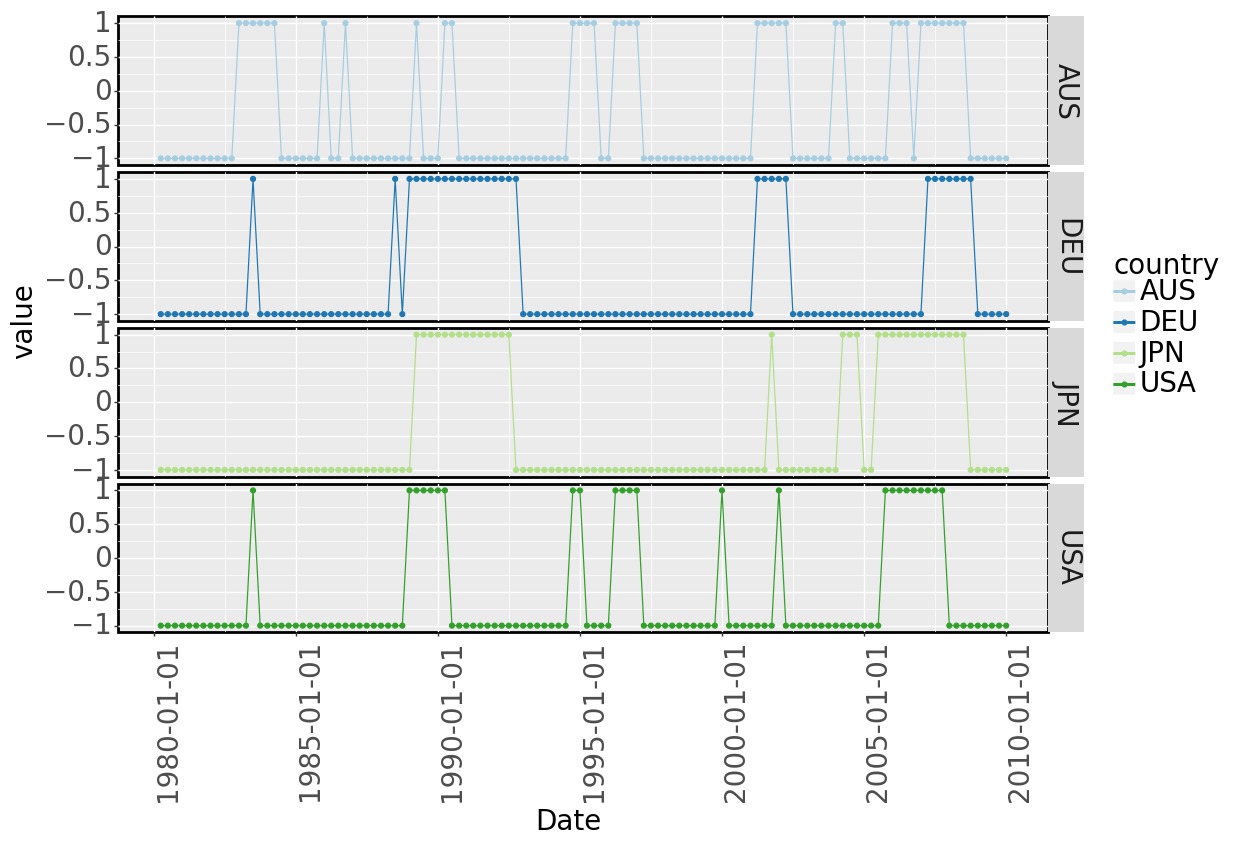

<ggplot: (8751839881834)>

In [26]:
lr_deriv = mask(dlib.pull('LongRates'))
lr_deriv = lr_deriv.resample('Q').mean()
lr_deriv = derivative(lr_deriv)
lr_deriv = lr_deriv.rolling(12).mean()
lr_deriv = lr_deriv.applymap(lambda x: 1 if x > 0 else -1)
lr_deriv = Signal('LR Derivative', lr_deriv, normalizer=lambda x: x)

lr_deriv.plot() + facet_grid('country~.')

In [27]:
a = (lr_deriv.long_form()['value'] < 0).mean()
print(a)
a ** 2 + (1 - a) ** 2

0.7479166666666667


0.6229253472222223

# GDP

/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/normalization.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: x[:window - gap].mean()
/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/normalization.py:29: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: x[:window - gap].mean()
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/home/dcdanko/

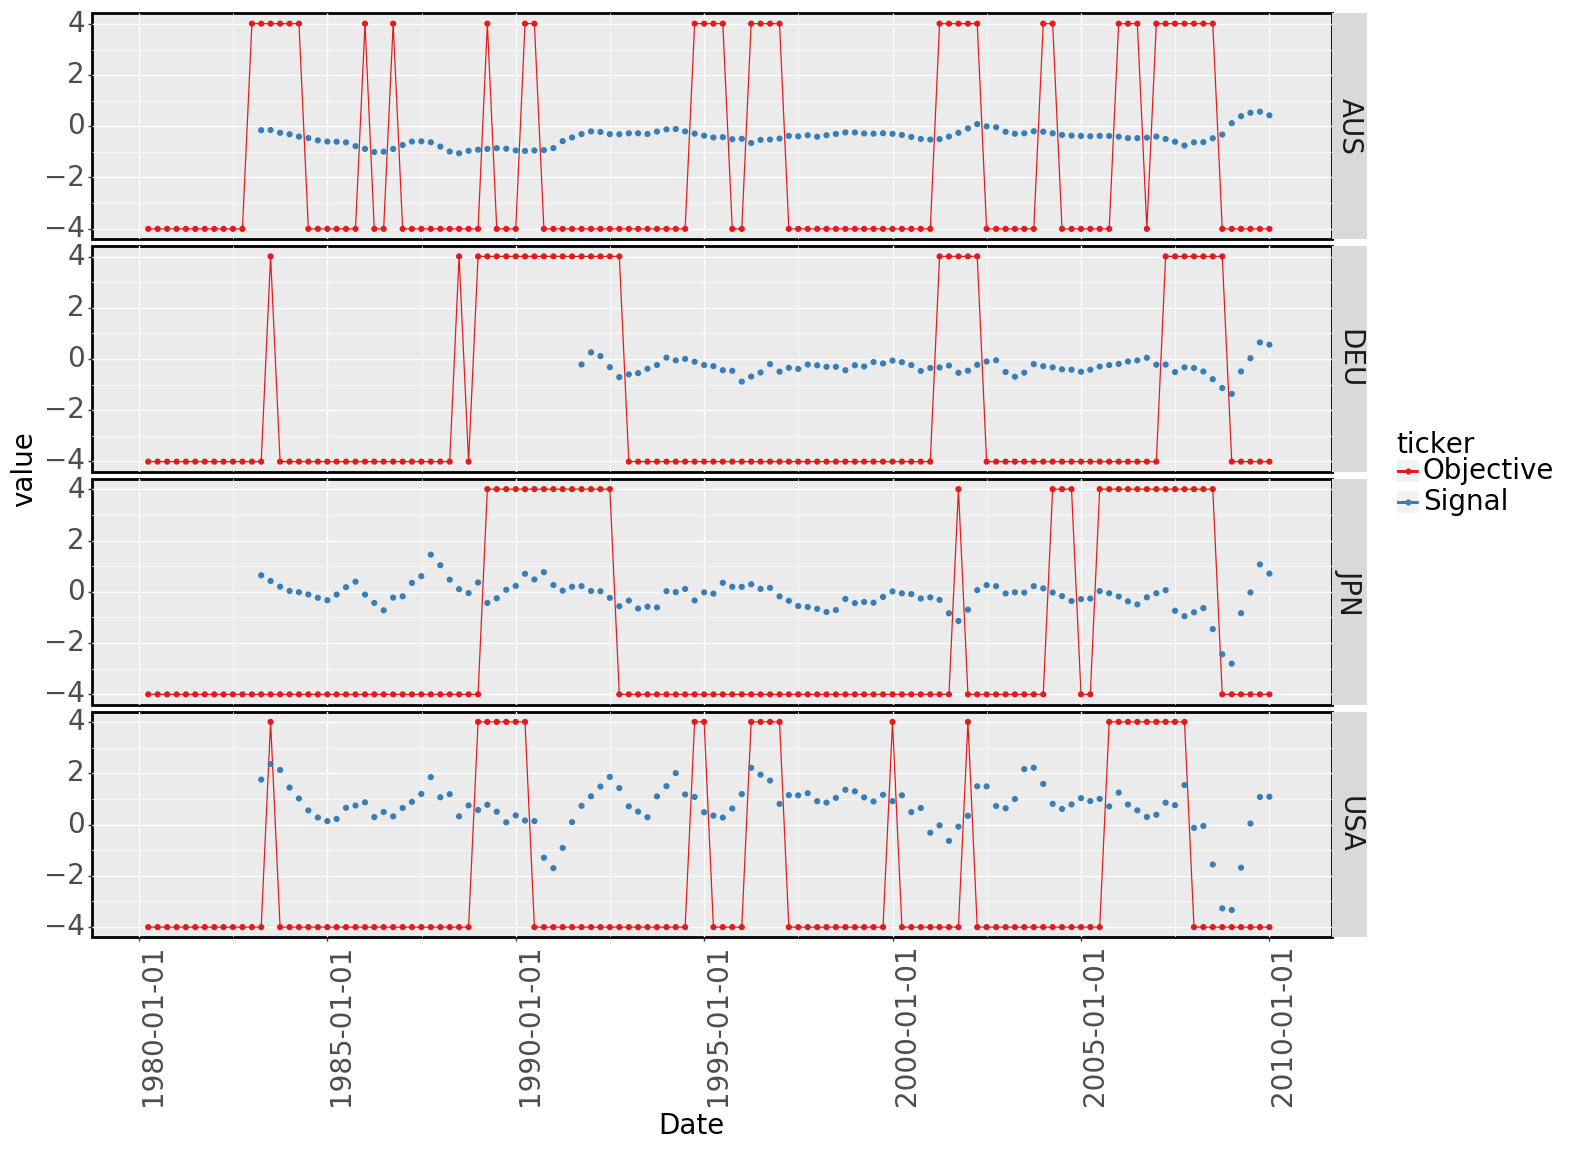

<ggplot: (8751830931990)>

In [121]:
gdp = mask(dlib.pull('GDP-Real'))
gdp = derivative(gdp, s=1).rolling(3).mean()
gdp = Signal('GDP', gdp)

plot_signal_against_objective(gdp, lr_deriv)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

-0.023359431782992744
-0.03669722978028499


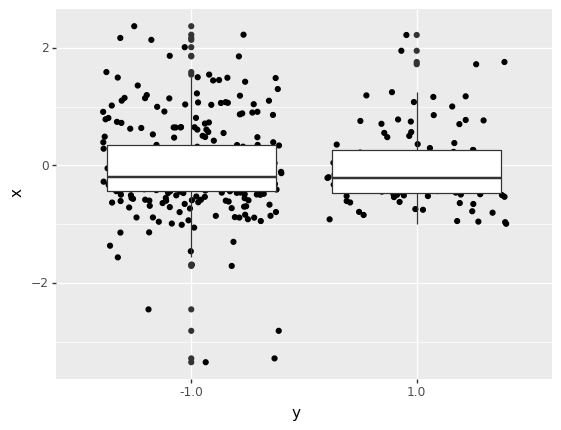

(0.6202020202020202, Predicted  -1.0   1.0
 Actual               
 -1.0        542   186
  1.0        190    72, <ggplot: (-9223363285023950241)>)

In [29]:
predictive_accuracy(gdp, lr_deriv)

# Relative Asset Performance

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


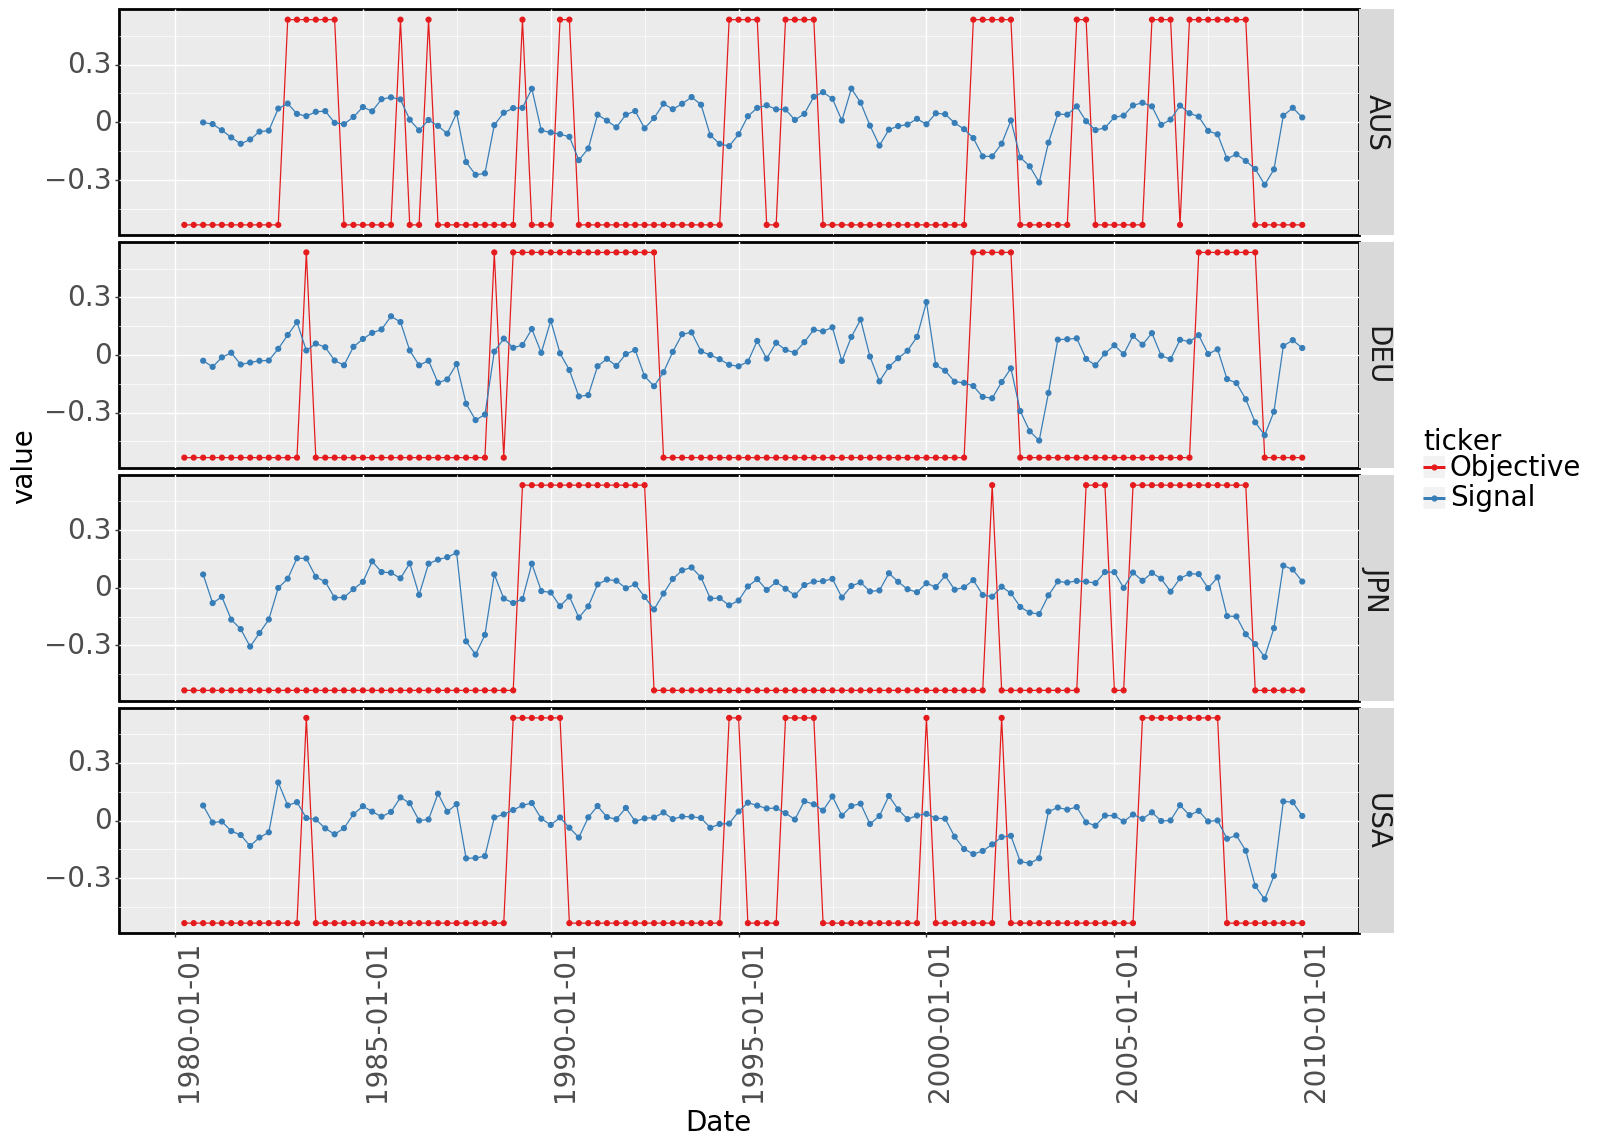

<ggplot: (-9223363285047045979)>

In [47]:
eqs = mask(dlib.pull('EquityPrices')).resample('Q').mean()
eqs = eqs.rolling(4).apply(lambda x: x[3] / x[:3].max()).applymap(lambda x: x - 1)
#eqs = derivative(eqs, s=1).rolling(1).mean()
eqs = Signal('Equity Prices', eqs, normalizer=lambda x: x)

plot_signal_against_objective(eqs, lr_deriv)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

-0.010421863909671293
-0.01588196999973539


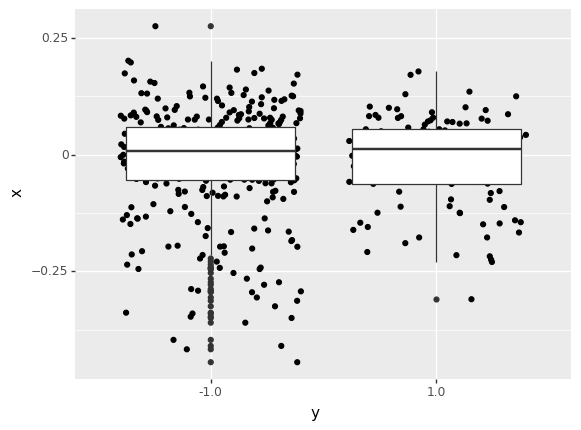

(0.6538461538461539, Predicted  -1.0   1.0
 Actual               
 -1.0        673   214
  1.0        191    92, <ggplot: (8751807849294)>)

In [48]:
predictive_accuracy(eqs, lr_deriv)

# Combined

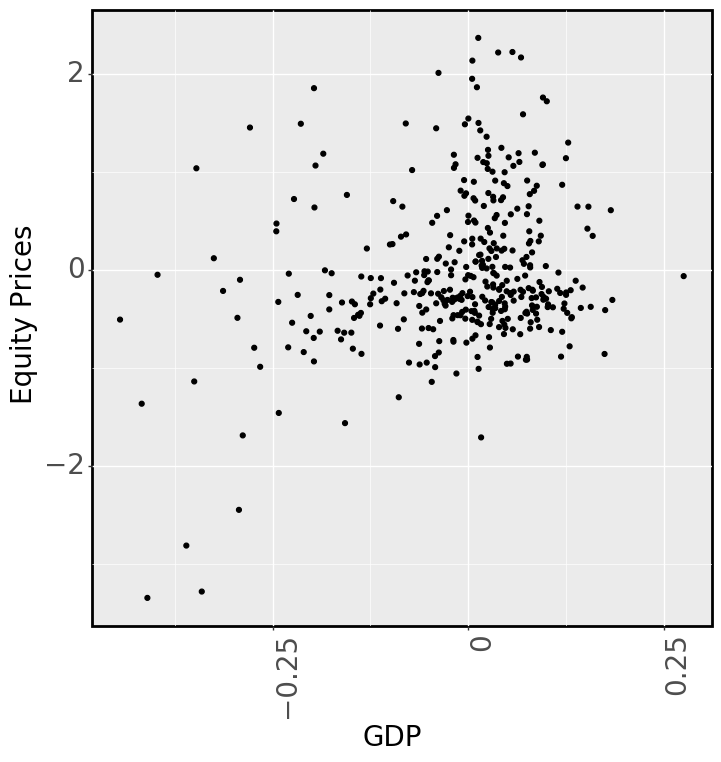

<ggplot: (8751806876266)>

In [49]:
def scatter(X, Y):
    x = X.long_form().dropna().set_index(['date', 'country'])
    y = Y.long_form().dropna().set_index(['date', 'country'])
    tbl = pd.concat([x, y], axis=1).dropna()
    tbl.columns = ['x', 'y']
    plot = (
        ggplot(tbl, aes(x='y', y='x')) +
            geom_point() +
            xlab(X.name) +
            ylab(Y.name) +
            theme(
                text=element_text(size=20),
                figure_size=(8, 8),
                legend_position='right',
                axis_text_x=element_text(size=20, angle=90, hjust=0),
                panel_border=element_rect(colour="black", size=2),
            )
    )
    return plot


scatter(gdp, eqs)

In [116]:

comb = Indicator('combined', gdp, eqs)

def divergence_from_mean(tbl):
    row = tbl.iloc[-1]
    diff = (row - row.mean()).abs().sum()
    return diff

def divergence_from_median(tbl):
    row = tbl.iloc[-1]
    diff = (row - row.mean()).abs().sum()
    return diff

comb.metrics['div_from_mean'] = divergence_from_mean
comb.metrics['div_from_median'] = divergence_from_median

comb

In [81]:
mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()

country,USA,JPN,AUS,DEU
date,,,,
1980Q1,34.746231,NaN,NaN,47.398092
1980Q2,38.692323,NaN,NaN,48.145262
1980Q3,38.779985,NaN,NaN,51.624788
1980Q4,37.179242,NaN,NaN,50.437091
1981Q1,37.430969,NaN,NaN,48.528766
...,...,...,...,...
2009Q1,439.506438,252.545813,788.084578,380.007531
2009Q2,421.716800,249.738600,749.373554,375.209677
2009Q3,417.841182,253.375000,734.459818,381.173333


# Indicator Returns

In [113]:

def get_optimal_signal(dlib):
    optimal_signal = mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()
    optimal_signal = (optimal_signal.pct_change() + 1)

    def minmaxsig(row):
        out = row.copy().fillna(0)
        out[:] = 0
        out[row.idxmax()] = 1
        out[row.idxmin()] = -1
        return out

    optimal_signal = optimal_signal.apply(minmaxsig, axis=1)
    optimal_signal = optimal_signal.drop(columns=optimal_signal.columns[4])
    return optimal_signal
    
optimal_signal = get_optimal_signal(dlib)
optimal_signal

,AUS,DEU,JPN,USA
date,,,,
1980Q1,0.0,0.0,0.0,0.0
1980Q2,0.0,-1.0,0.0,1.0
1980Q3,0.0,1.0,0.0,-1.0
1980Q4,0.0,1.0,0.0,-1.0
1981Q1,0.0,-1.0,0.0,1.0
...,...,...,...,...
2009Q1,1.0,0.0,-1.0,0.0
2009Q2,-1.0,0.0,1.0,0.0
2009Q3,-1.0,1.0,0.0,0.0


In [199]:
def get_random_signal(dlib):
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()
    random_signal = np.random.random(size=bond_returns.shape)
    random_signal = pd.DataFrame(random_signal, columns=bond_returns.columns, index=bond_returns.index)
    random_signal = random_signal.T
    random_signal = random_signal - random_signal.mean()
    random_signal = random_signal / random_signal.abs().max()
    random_signal = random_signal.T
    return random_signal
    
random_signal = get_random_signal(dlib)
random_signal  


country,USA,JPN,AUS,DEU
date,,,,
1980Q1,0.787853,-1.000000,-0.175231,0.387378
1980Q2,-1.000000,0.071110,0.319585,0.609305
1980Q3,0.833833,-0.930804,1.000000,-0.903028
1980Q4,0.228382,-0.284219,1.000000,-0.944163
1981Q1,0.345732,0.199510,0.454758,-1.000000
...,...,...,...,...
2009Q1,-0.185803,-1.000000,0.766040,0.419763
2009Q2,-0.995843,-0.981302,0.977145,1.000000
2009Q3,0.918954,0.605345,-1.000000,-0.524298


In [200]:

def calc_signal_returns(dlib, signal):
    signal = signal.copy().fillna(0)
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()
    bond_returns = bond_returns.pct_change()
    bond_returns = bond_returns.fillna(0)
    bond_returns += 1

    signal_returns = bond_returns * signal
    signal_returns = (signal_returns.sum(axis=1) + 1)
    signal_returns = signal_returns.cumprod()
    return signal_returns

optimal_returns = calc_signal_returns(dlib, optimal_signal)
optimal_returns

date
1980Q1     1.000000
1980Q2     1.097805
1980Q3     1.174658
1980Q4     1.196120
1981Q1     1.249475
            ...    
2009Q1    68.559659
2009Q2    71.165251
2009Q3    73.712668
2009Q4    74.253336
2010Q1    76.660543
Freq: Q-DEC, Length: 121, dtype: float64

In [201]:
random_returns = calc_signal_returns(dlib, random_signal)
random_returns

date
1980Q1    1.000000
1980Q2    0.896036
1980Q3    0.839251
1980Q4    0.849569
1981Q1    0.883702
            ...   
2009Q1    0.819549
2009Q2    0.811839
2009Q3    0.821530
2009Q4    0.816482
2010Q1    0.810810
Freq: Q-DEC, Length: 121, dtype: float64

In [202]:

gdp_sig = gdp.data.resample('Q').mean()
gdp_sig = gdp_sig.T
gdp_sig = gdp_sig - gdp_sig.mean()
gdp_sig = gdp_sig / gdp_sig.abs().max()
gdp_sig = gdp_sig.T

gdp_returns = calc_signal_returns(dlib, gdp_sig)
gdp_returns

date
1980Q1    1.000000
1980Q2    1.000000
1980Q3    1.000000
1980Q4    1.000000
1981Q1    1.000000
            ...   
2009Q1    1.159449
2009Q2    1.148621
2009Q3    1.115917
2009Q4    1.108603
2010Q1    1.086929
Freq: Q-DEC, Length: 121, dtype: float64

In [203]:
eqs_sig = eqs.data.resample('Q').mean()
eqs_sig = eqs_sig.T
eqs_sig = eqs_sig - eqs_sig.mean()
eqs_sig = eqs_sig / eqs_sig.abs().max()
eqs_sig = eqs_sig.T

eqs_returns = calc_signal_returns(dlib, eqs_sig)
eqs_returns

date
1980Q1    1.000000
1980Q2    1.000000
1980Q3    1.000000
1980Q4    0.988763
1981Q1    1.014156
            ...   
2009Q1    1.460837
2009Q2    1.471003
2009Q3    1.497361
2009Q4    1.486851
2010Q1    1.520962
Freq: Q-DEC, Length: 121, dtype: float64

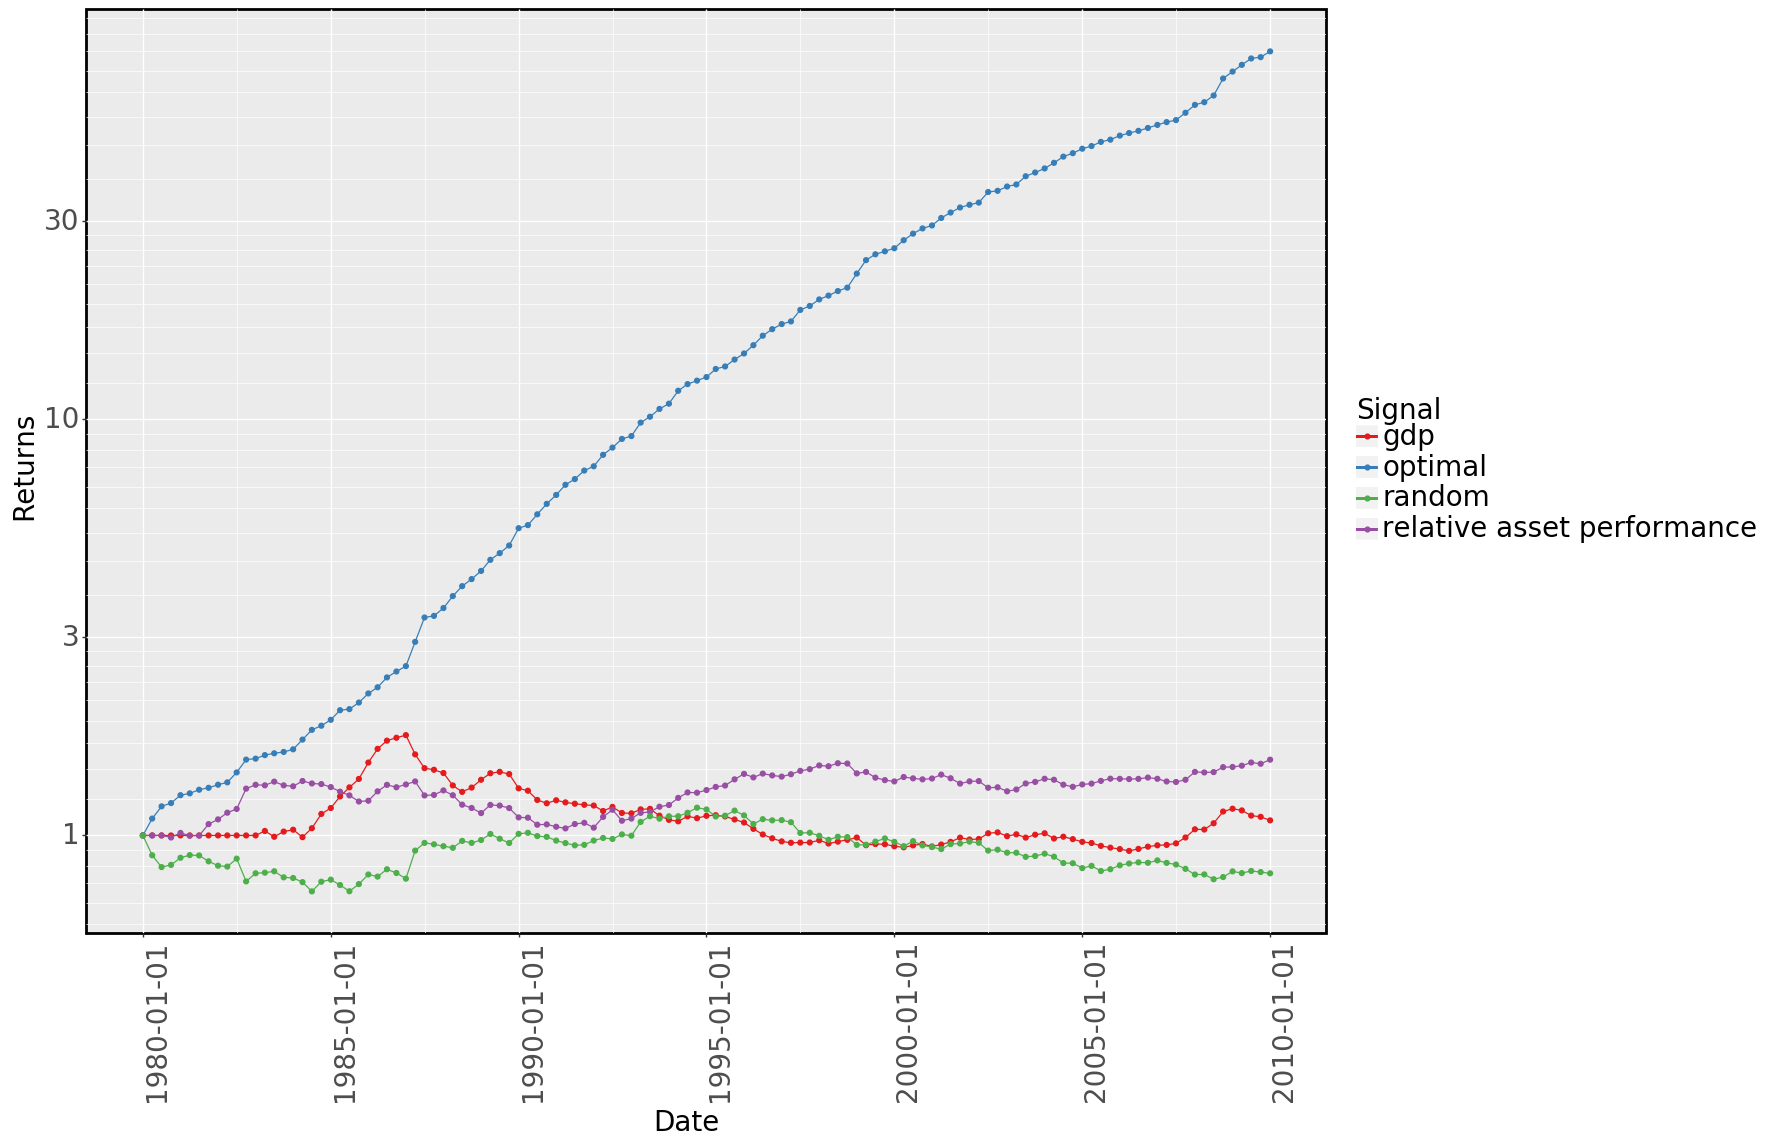

<ggplot: (8751807968716)>

In [204]:
df = pd.DataFrame({
    'gdp': gdp_returns,
    'optimal': optimal_returns,
    'relative asset performance': eqs_returns,
    'random': random_returns,
})
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')

(
    ggplot(df, aes(x='date', y='value', color='variable')) +
        geom_line() +
        geom_point() +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)